# Hypothesis tests

In this Notebook I´m going to clarify some aspects of one fundamental data analyst tool: **Hypothesis tests**

We will have a walk over:

- $\mathit{z}$-Scores
- $\mathit{p}$-Values
- Confidence Intervals
- $\mathit{t}$-Tests
- ANOVA
- Tests for single and two proportions
- Proportions $\mathit{z}$-test
- ${Chi^{2}}$ tests
- Wilcoxon tests
- Wilcoxon-Man-Whotney tests
- Kruskal-Wallis tests

## Definitions

So, first of all, what is a hypothesis tests?

**Hypothesis tests** is a mathematical procedure that allow us to generalize hypothesis / properties that we supposed based on our data, so what we deduce from our sample could be a real property of that population.

**A/B Testing** is a process that allow us to check outcomes of competing scenarios and decide which way to proceed depending of the results that this scenarios provide us. 
- For example, if we are in the medicine field, a common hypothesis test is to separate two groups of people to give them medicine and placebo respectivelly in order to see if the medicine really works or it is based on the suggestion of the patient. 
- Another example is when you perform a separation in a website in order to have two websites and see the SEO, how it is positioning, how is it listed on the internet and decide which interface is better.
  
A/B Testing is the main application of Hypothesis tests.

!["A/B Testing Image"](https://www.optimizely.com/contentassets/08726e145f1b4743a0ba2f30c0447b76/ab-testing.png)

# Hypothesis testing fundamentals

To learn more about hypothesis tests, we will be working with two datasets, one that is called *late_shipments* and the other one called *republican_votes*. Right now we will be using only the first one in order to understand more about hypothesis tests.

The *late_shipments* dataset contains supply chain data on the delivery of medical supplies. Each row represents one delivery of a part. 
- The **"late"** columns denotes whether or not the part was delivered late. A value of "Yes" means that the part was delivered late, and a value of "No" means the part was delivered on time.

## Packages and dataset main idea

In [24]:
import pandas as pd
import pyarrow.feather as feather
import numpy as np
from scipy.stats import norm

Let´s find some information first about the shipments, how many of them are late shipments? First, as we usually do we have a previsualization of the datasets.

In [25]:
late_shipments = feather.read_feather("late_shipments.feather")
late_shipments.head()

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2996.0,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83
1,30998.0,Botswana,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,25.0,800.00,32.00,1.60,"Trinity Biotech, Plc",Yes,10.0,559.89,reasonable,1.72
2,69871.0,Vietnam,PMO - US,Direct Drop,EXW,Air,0.0,No,ARV,Adult,...,22925.0,110040.00,4.80,0.08,Hetero Unit III Hyderabad IN,Yes,3723.0,19056.13,expensive,181.57
3,17648.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,152535.0,361507.95,2.37,0.04,"Aurobindo Unit III, India",Yes,7698.0,11372.23,expensive,779.41
4,5647.0,Uganda,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test - Ancillary,...,850.0,8.50,0.01,0.00,Inverness Japan,Yes,56.0,360.00,reasonable,0.01


We can know this by having a look to the column *"late"* and making a proportion. As it is a *dummy variable*, we only have to take the mean.

In [26]:
# Calculate the proportion of late shipments
late_prop_samp = (late_shipments["late"]=="Yes").mean()
print(late_prop_samp)

0.061


So we obtain that **6.1%** of the shipments are late. 
The point is, **can we make this results general for every sample of our shipments**? 

## Z-Score

Imagine that you are in your house with your cousin from Romania and you want to compare how much money do you have in your piggy bank! It is usually use to save money specially as a child to learn a bit of finances and self-control, and both of you want to know who is the best one saving money for some ice cream! 💰🐷

Then, you decide to open the piggy bank (Opening means 🔨), but, when you open it you discover something...
Your cousing has Leis on it! The standard coind in Romania while you have Euros! How are you going to compare both quantities?
Your cousin could have saved 6 coins, but the value of his coins not the same as yours... What can we do?

**This is the purpose of the $\mathit{z}$-Score, to standarized the value of interest for our statistic.**

To calculate it, you need three numbers: 
- The sample statistic (point estimate)
- The hypothesized statistic
- The standard error of the statistic (estimated from the bootstrap distribution)


Now, we are going to calculate the $\mathit{z}$-Score <a id='z-Score'></a>
 of our problem, this is, we are going to compare samples of our shipments population and see if they are really deviated from the media of our hypothesis.

Our numbers are:
- The sample statistic, we will pick samples from it **using a BootStrap distribution**.
- The hypothesized statistic, this is **0.06** (or 6%)
- The standard error of the statistic, **we can calculate it from the first number with NumPy**.

$$ \mathit{z}-Score = \frac{Sample stat - Hypot. param. value}{Standard error}$$

1. Sample statistic with Bootstrap Sampling:

In [27]:
#--------------------------BootStrap-Sampling------------------

late_shipments['late'] = late_shipments['late'].map({'Yes': 1, 'No': 0}) #Tranform the strings into ints
#-----Looping----------

late_shipments_boot_distn = []
for i in range(1000):
    late_shipments_boot_distn.append(
        np.mean(
            late_shipments.sample(frac=1,replace = True)["late"]
    )
)

2. Hypothesized statistic

In [28]:
late_prop_hyp = 0.06

3. Standard error from the Bootstrap Distribution

In [29]:
std_error = np.std(late_shipments_boot_distn, ddof=1)
std_error

0.007650626319660574

So we calculate the $\mathit{z}$-score:

In [30]:
z_score = (late_prop_samp - late_prop_hyp) / std_error
# Print z_score
print(z_score)

0.1307082529217512


So, we obtain that the standarized measure difference is 0.13255 aproximately!

-----------------------------

## p-Value

### Hypothesis and tails

We will now see why $\mathit{z}$-Score is so important and what is the relation that it has with $\mathit{p}$-Value!

But first, it is mandatory to explain some things! Imagine that your cousin and you are arguing about your money: Is it the same? Does he have more than you? And the opposite case?

All of this assumptions are hypothesis.**A hypothesis is a statement about an unknown population parameter.**
When we are comparing two hypothesis to see which one is true it is called a **hypothesis test**. These hypothesis are called:

- Null hypothesis ($H_{0}$) which is the existing idea.
- Alternative hypothesis ($H_{A}$) that is the one that challenges the previous idea.

In our case it could be that our $H_{0}$ has more money than and the $H_{A}$ is that he do not have more money than I.

![Money fight](https://www.lovelearnings.com/wp-content/uploads/2015/01/Money-Fight.jpg)


Now, there could be two options, **or $H_{0}$ is true or $H_{A}$ is true.**

We assume first that $H_{0}$ is true. So the two options are the following:
- Rejecting $H_{0}$
- Failing to reject $H_{0}$
If the evidence from the sample is "significant" that $H_{A}$ is true, then we reject $H_{0}$.

### Why do we do hypothesis test?

**OK! But what is the difference between this and comparing our quantities directly, why don´t we do that?**

Because we are trying to make a generalization of a certain phenomena in our population. For example, there could be season were you spend more money than your romanian cousin, does it mean that we can assume that you have less money than him? No.

But in the other case that he has spend more, for example during the last week and you have more money that week, does it mean that you have more money than him general? Neither.

**That´s why we have to make bootstrapping! To take a lot of samples, and then we can assume one of the results with a certain precision!**

That precision is called **significance level**.

## Possible hypothesis tests

What we are mathematically doing is looking at the distribution of the data in a normal distribution based on the null hypothesis, and, from our samples, we determine if these are in a "common area" or they are in the tails. 

Being in the tails would mean that our assumption of that hypothesis is not appropiate as they are not in the central area of the hypothesis!

There are 3 options:

- If we are checking if there are differences, for examples *"my cousin and I have different quantities of money*", that´s a *"two-tailed test"*.
- If we are comparing with a greater than affirmation, such as *"my cousin has more money than I"*, that´s a right-tailed test.
- If we are comparing with a less than affirmation, such as *"my cousin has less money than I"*, that´s a left-tailed test.

And here, is when **$\mathit{p}$-Value** enters!

**$\mathit{p}$-Value** is the probability of obtaining a result assuming that the null hypothesis is true. This value that leads this distribution, is the Z-Score!

- For example if we have a high p-Value in a distribution that is based on "My cousin have more money than I", that would mean that, exactly, it is most-probable that he has more money so it is a solid hypothesis!

- Nevertheless, if the p-Value is low in a distribution that is based on "My cousin have more money than I", that would mean that is most probable that he don´t have more money than you. In other words, that assumptions has a probability close to 0 of being true.

Have you seen the similarities yet? They are in front of you! 

- **If we have a high p-Value that do not surpasses certain threshold, we will fail to reject $H_{0}$.**

- **If we have a low p-Value that surpasses certain threshold, we will reject $H_{0}$ and we will keep $H_{A}$.**

Let´s learn how to obtain the $\mathit{p}$-Value.

------------------------------

### How do we present it our case

In our case we can see that:

- We have a proportion of late shipments that is 6.1%
- We estimated the proportion of late shipments in 6%

- Our null hypothesis is that **the proportion of late shipments is 6%**
- Our alternative hypothesis is that **the proportion of late shipments is more than 6%**

Se we would need to perform a right-tailed test.

In [31]:
#Usign the package scipy.stats
#Because it is a right-tailed test we do 1-cdf (Total probability - the probability of being in the left side.)

p_value = 1 - norm.cdf(z_score,loc=0, scale=1)   
p_value

0.4480030517365925

## Confidence intervals

Now that we have a number, which is the threshold to consider it as accepted or rejected?

It is called the **significance level** and is a threshold point for "beyond a reasonable doubt".

- In case that is is true: $$p \leq \alpha$$

We reject the null hypothesis $H_{0}$. In other case we fail the reject $H_{0}$.
The usual value of $\alpha$ is 0.05, so the confidence interval is 95%, it is 1-$\alpha$.

For example, the hypothesized proportion of late shipments was 6%. Even if evidence suggests the null hypothesis that the proportion of late shipments is equal to this, for any new sample of shipments, the proportion is likely to be a little different due to sampling variability. Consequently, it's a good idea to state a confidence interval.

In [32]:
# Our 95% confidence interval is:
lower = np.quantile(late_shipments_boot_distn,0.025)
upper = np.quantile(late_shipments_boot_distn,0.975)

print((lower, upper))

(0.048, 0.077)


We would be saying that we are 95% confident that the proportion of late shipments is between 4.6% and 7.6%.

So, the conclusions for this hypothesis test would be, does the confidence interval match with the conclusion to stick with the original assumption that 6% is a reasonable value for the unknown population parameter?

**The answer is Yes, because 0.06 is included in the confidence interval and we failed to reject $H_{0}$, due to a large $\mathit{p}$-Value.**

But also, we see that: $$p > \alpha$$

Remember that p = 0.44 aprox. while $\alpha$ = 0.05. That means that we fail to reject $H_{0}$ so we keep it.

We have found two ways to solve the same problem.

----------------------------

# Two sample tests

## T-Test

$\mathit{t}$-Test is another type of test that allows us to compare statistics between two groups, concretely the mean of the groups. 
We can obtain a solid conclusion about information of the groups.

- For example, if we would be interested in knowing if german beer has more alcohol than belgian beer, we would have the following hypothesis:

- $H_{0}$: German beer has more alcohol content than belgian beer. $\mu_{German} > \mu_{Belgian}$
- $H_{A}$: German beer have the same alcohol content than belgian beer. $\mu_{German} = \mu_{Belgian}$

We would be **comparing the means** of both alcoholic content from the groups of beers. We would need to apply a $\mathit{t}$-Test.

Notice that they could be written also as:
$$ H_{0}: \mu_{German} > \mu_{Belgian}$$
$$ H_{A}: \mu_{German} = \mu_{Belgian}$$

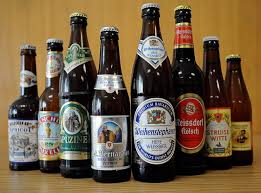

---------------------

## A new form of z-Score

As we are doing another test, we need a $\mathit{z}$-Score to calculate later the $\mathit{p}$-Value.

What happens now? Now that we have 2 samples as the population is divided in 2 types, the German and Belgian beers, we need to take the difference between the samples in all of the cases. This means, that calculating the $\mathit{z}$-Score now is done in the following way:

$$\mathit{t} = \frac{(\bar{x}_{German} - \bar{x}_{Belgian}) - (\mu_{German} - \mu_{Belgian})}{\mathit{SE}(\bar{x}_{German} - \bar{x}_{Belgian})}$$

Where $\mathit{SE}(\bar{x}_{German} - \bar{x}_{Belgian})$ is:

$$\mathit{SE}(\bar{x}_{German} - \bar{x}_{Belgian}) \approx \sqrt{\frac{\mathit{s}^{2}_{German}}{n_{German}} + \frac{\mathit{s}^{2}_{Belgian}}{n_{Belgian}}}$$

- $\mathit{s}$ is the standard deviation of the variable.
- $\mathit{n}$ is the sample size.


## Simplifying this

Ok but this sounds so difficult, how can be simplify it? 

Do you remember that when we were doing our calculus of the $\mathit{p}$-Value we were assuming that the null hypothesis is true? If we consider that to be true, in our last example we would have:

$$ \bar{x}_{German} = \bar{x}_{Belgian}$$

Which would simplify the way we calculate $\mathit{t}$, so it is remaining:

$$\mathit{t} = \frac{(\mu_{German} - \mu_{Belgian})}{\mathit{SE}(\bar{x}_{German} - \bar{x}_{Belgian})}$$

So, then **we need 6 variables:**

- 2 means, one of each group.
- 2 standard deviations, one of each group.
- The number of observations for each group.

-------------------------

Doing this with our sample of late shipments would be in the following way. Our hypothesis are:

- $H_{0}$ = The mean weight of shipments that weren't late is the same as the mean weight of shipments that were late.
- $H_{A}$ = The mean weight of shipments that weren't late is LESS THAN the mean weight of shipments that were late.

In [33]:
late_shipments['late'] = late_shipments['late'].map({1: 'Yes', 0: 'No'})

# Sample means
xbar_yes = late_shipments[late_shipments["late"]=="Yes"].weight_kilograms.mean()
xbar_no = late_shipments[late_shipments["late"]=="No"].weight_kilograms.mean()

# Sample standard deviations
s_yes = late_shipments[late_shipments["late"]=="Yes"].weight_kilograms.std()
s_no = late_shipments[late_shipments["late"]=="No"].weight_kilograms.std()

# Number of elements of each group
n_yes = len(late_shipments[late_shipments["late"] == "Yes"])
n_no = len(late_shipments[late_shipments["late"] == "No"])

numerator = xbar_yes - xbar_no
denominator = np.sqrt(s_yes**2/n_yes + s_no**2/n_no)

t_stat = numerator/denominator
t_stat

2.3936661778766433